### Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

import kde_funcs as kde

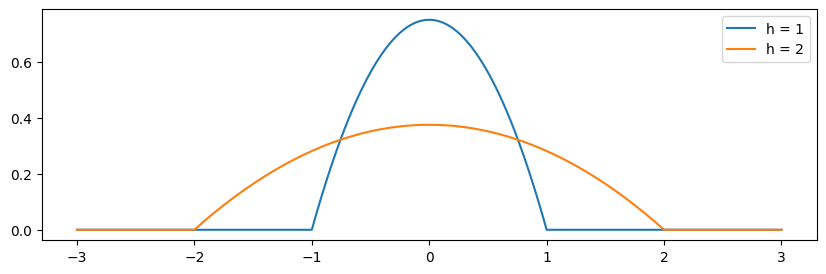

In [3]:
h = 2
x_arr = np.linspace(-3, 3, 1000)

plt.figure(figsize=(10, 3))
plt.plot(x_arr, kde.kernel_epa(x_arr), label='h = 1')
plt.plot(x_arr, (1/h) * kde.kernel_epa(x_arr / h), label=f'h = {h}')

plt.legend()
plt.show()

### naive NW estimator

In [4]:
def nadaraya_watson(x_obs, y_obs, x_pred, kernel, h=1):

    """
    VL - Nichtparametrische Stat 

    Def 4.2 Nadaraya-Watson-Schätzer

    f_{n, h}^{NW} (x) = \frac {\sum Y_i K(x-x_i)}{\sum K(x-x_i)}} 

    """

    y_pred = np.zeros(x_pred.shape[0])

    if kernel == 'epa':
        kernel_func = kde.kernel_epa
    if kernel == 'gauss':
        kernel_func = kde.kernel_gauss
    if kernel == 'rect':
        kernel_func = kde.kernel_rect
    if kernel == 'tri':
        kernel_func = kde.kernel_tri
    if kernel == 'sinc':
        kernel_func = kde.kernel_sinc

    # for each evaluation point

        # w = evaluate kernel function of each observation at evaluation point
        # w * y = multiply with respective y_obs
        # y_pred = w * y / sum(w)

    for i, x in enumerate(x_pred):
        
        w = kernel_func((x - x_obs) / h)
        sum_of_w = np.sum(w)

        # if np.sum(w) is 0 then set sum_of_w to 1
        # sum_of_w = np.sum(w) if (sum_of_w := np.sum(w)) != 0 else 1
        
        y_pred[i] = np.sum(w * y_obs / sum_of_w)
        
        # if value explodes, print some info
        # if np.abs(y_pred[i]) > 100:
        #     print('- '*10)
        #     print(f"y_pred = {y_pred[i]}")
        #     print(f"sum w = {np.sum(w)}")
        #     print(f"w = {np.round(w)}")
        #     print(f"y = {np.round(y_obs)}")

    return y_pred

#### PROBLEM !!!

In [5]:
# what to do with sum(w) = 0 if bandwidth is small and no x are in vicinity ?
# we need to divide by sum(w) in the end, so we need to check for this case ...
# do we divide by 1 then ???

#### illustrate problem with sinc kernel

C:\Users\ytl_c\AppData\Local\Temp\ipykernel_14408\1282455305.py:39: RuntimeWarning: divide by zero encountered in divide
  y_pred[i] = np.sum(w * y_obs / sum_of_w)
C:\Users\ytl_c\AppData\Local\Temp\ipykernel_14408\1282455305.py:39: RuntimeWarning: invalid value encountered in divide
  y_pred[i] = np.sum(w * y_obs / sum_of_w)


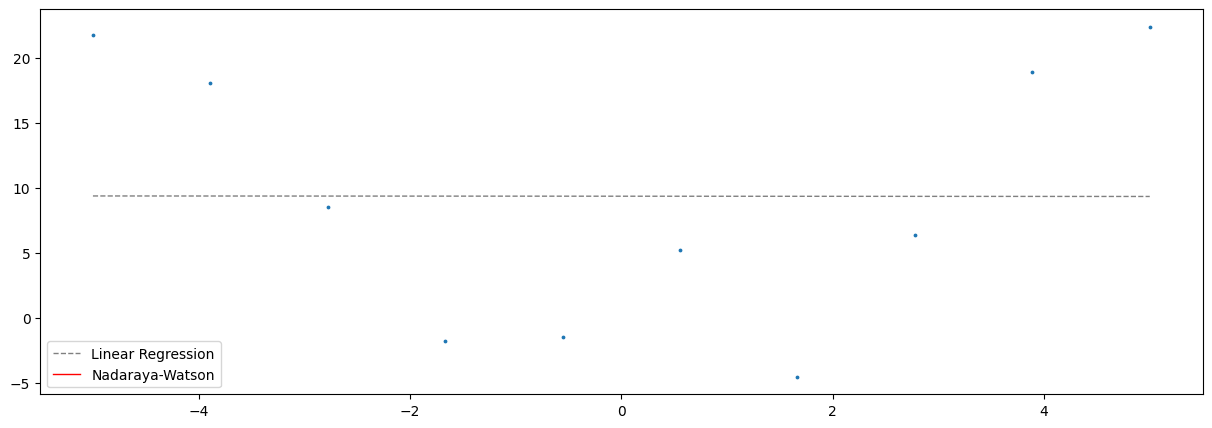

In [6]:
# simulation params
n = 10
x_min = -5
x_max = 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# print(f"observations at x = {x}")
y = x**2 + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n*100)
# print(f"making NW pred at {x_pred}")

# h = 0.1 * (1/np.pi) # = 0.03183098861837907
h = 0.01
y_pred_nw = nadaraya_watson(x, y, x_pred, 'epa', h=h)

# Plot the original data and the regression line
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=3)
plt.plot(x, y_pred, color='grey', ls='--', lw=1, label='Linear Regression')
plt.plot(x_pred, y_pred_nw, color='red', lw=1, label='Nadaraya-Watson')

plt.legend()
plt.show()

#### PROBLEM !!!

In [7]:
# PROBLEM with kernels that have negative values in naive NW estimator

# in the worst case scenario at some evaluation point x
# the kernel outputs cancel each other out in sum(K) and the sum gets really small ( in some cases even negative )
# therefore the effective weight w_i = K / sum(K) gets blown up

# even though the sum of the weights is still 1, the individual weights can get jumpy, eg :

# |  w   |  -44.0 |   2.0 |  12.0 |   1.0 |  -6.0 |  -2.0 |   4.0 |   2.0 |  -3.0 |
# |  y   |   24.0 |  10.0 |  10.0 |   9.0 |   0.0 |   5.0 |   5.0 |  17.0 |  26.0 |
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# | w*y  |  840.0 |  22.0 | 120.0 |   9.0 |   0.0 | -10.0 |  20.0 |  34.0 | -78.0 |
# | sum = 517

# therefore y_pred = sum( w_i * y_i ) gets blown up as well in both positive and negative directions

#### naive NW for diff kernels and h

C:\Users\ytl_c\AppData\Local\Temp\ipykernel_14408\1282455305.py:39: RuntimeWarning: invalid value encountered in divide
  y_pred[i] = np.sum(w * y_obs / sum_of_w)


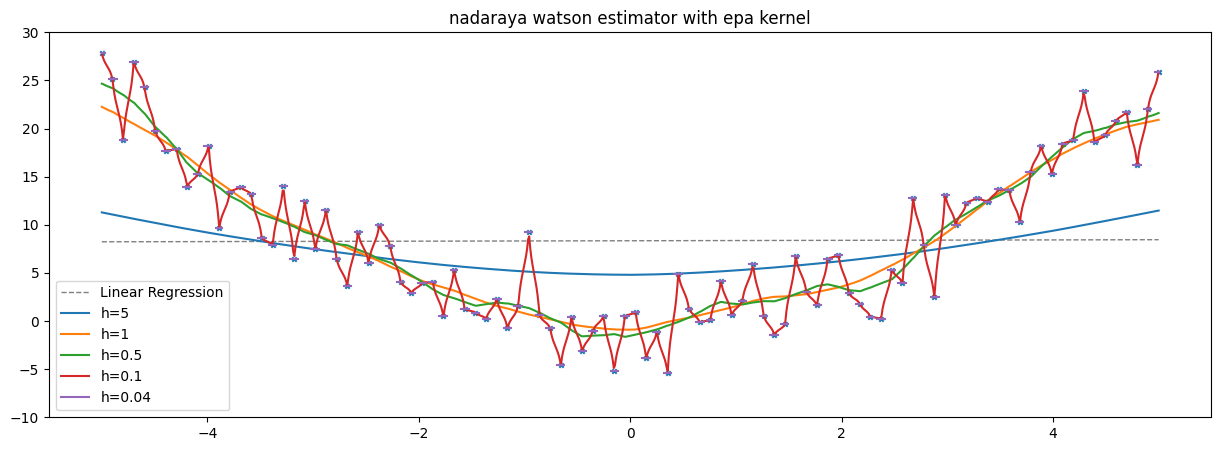

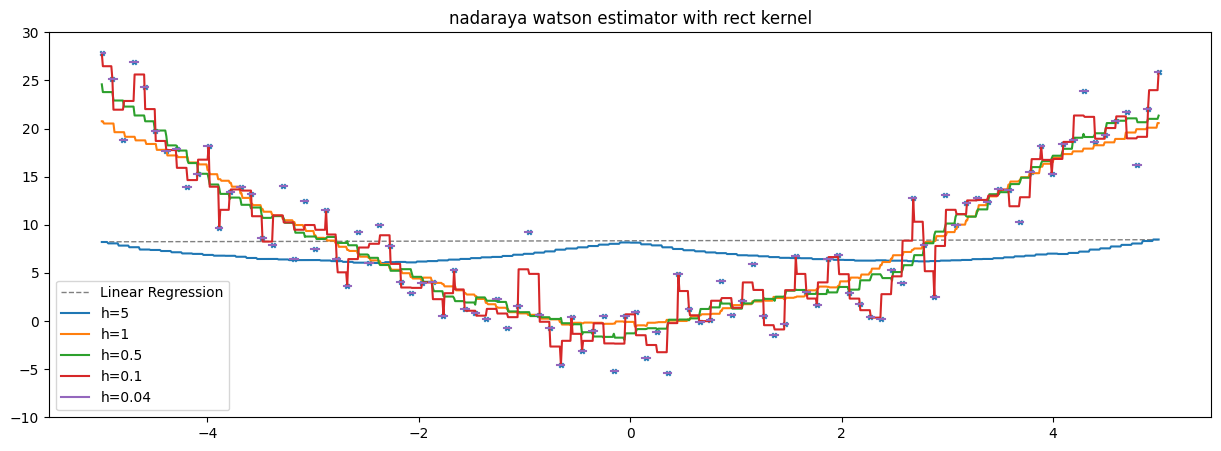

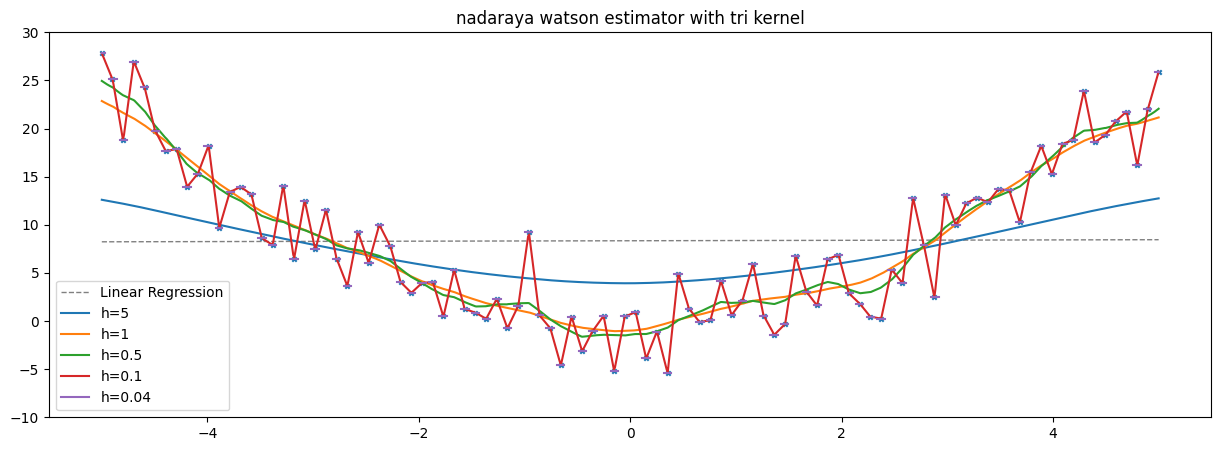

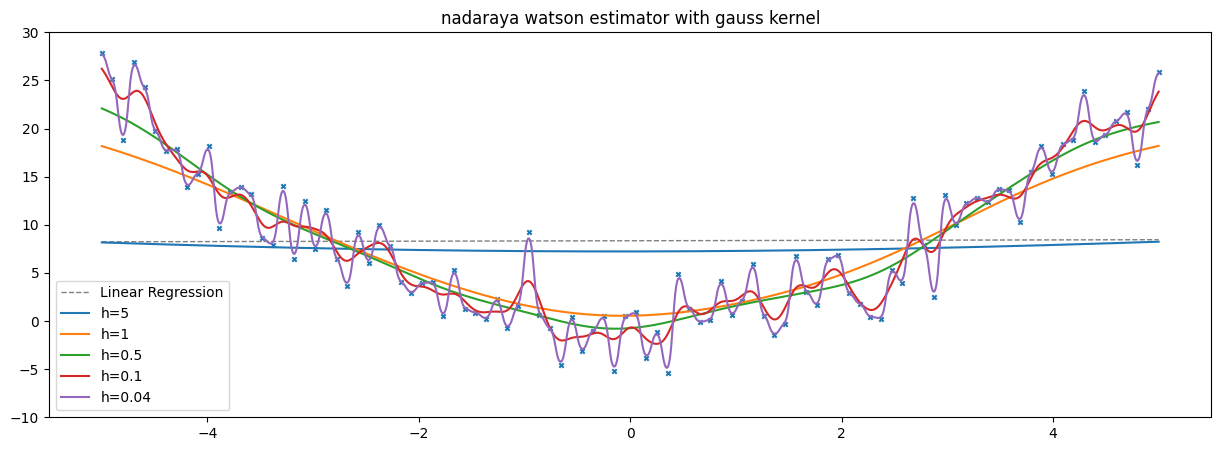

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\Kernel Simulations\kde_funcs.py:37: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, (1/np.pi), np.sin(x)/(np.pi*x))


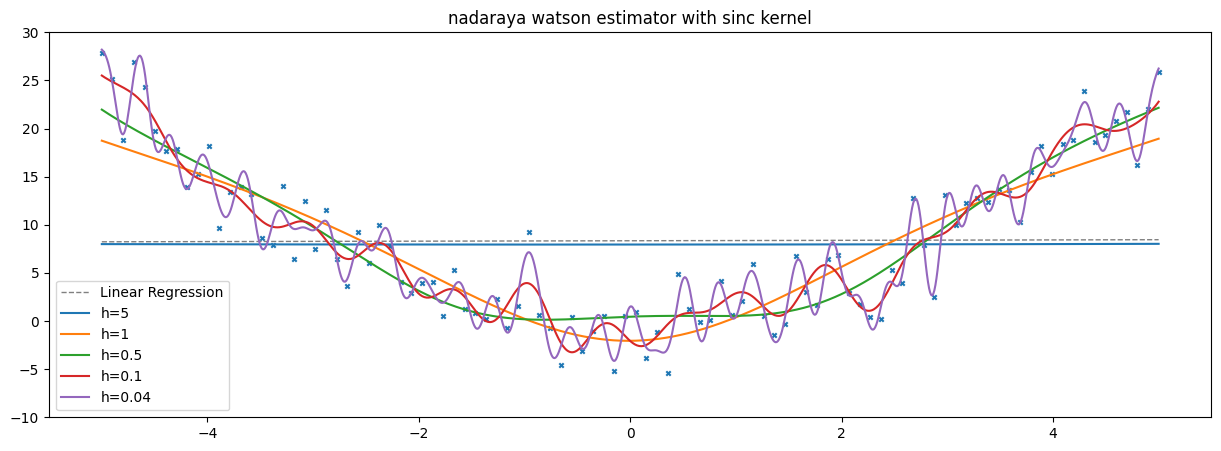

In [16]:
# simulation params
n = 100
x_min = -5
x_max = 5

# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# x = np.random.uniform(x_min, x_max, n) # random x point distribution

# print(f"observations at x = {x}")
y = x**2 + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n*10)
# print(f"making NW pred at {x_pred}")

kernel_types = ['epa', 'rect', 'tri', 'gauss', 'sinc']
h_arr = [5, 1, 0.5, 0.1, 0.04]

for kernel_type in kernel_types :

    plt.figure(figsize=(15, 5))
    plt.scatter(x, y, s=10, marker='x')
    plt.plot(x, y_pred, color='grey', ls='--', lw=1, label='Linear Regression')

    for h in h_arr :
        y_pred_nw = nadaraya_watson(x, y, x_pred, kernel_type, h=h)
        plt.plot(x_pred, y_pred_nw, lw=1.5, label=f'h={h}')

    plt.ylim(-10, 30)
    plt.title(f"nadaraya watson estimator with {kernel_type} kernel")
    plt.legend()
    plt.show()

#### compare with statsmodels

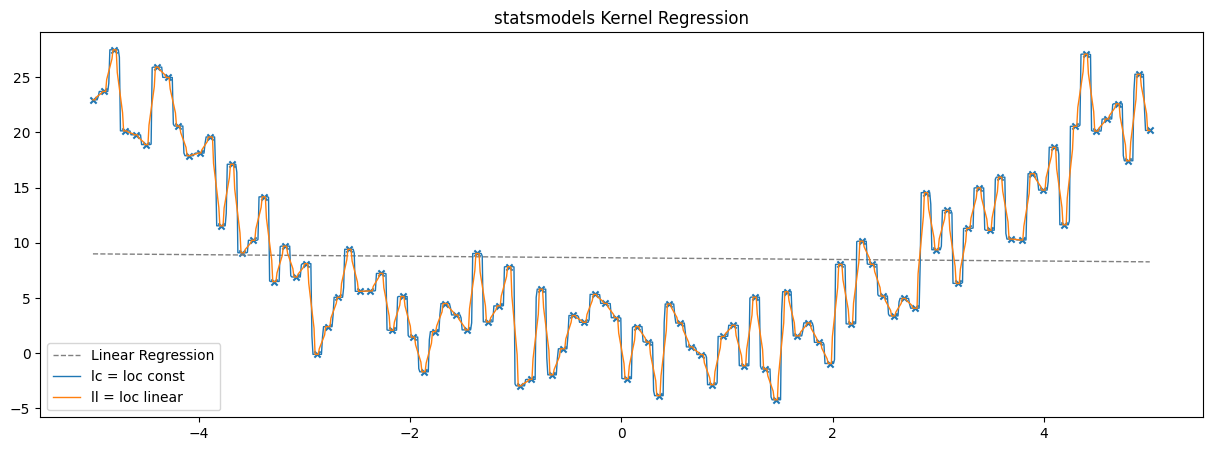

In [9]:
from statsmodels.nonparametric.kernel_regression import KernelReg

y_pred_sm_ll = KernelReg(y, x, var_type='c', reg_type='ll', ckertype='gaussian', bw=[0.01]).fit(x_pred)[0]
y_pred_sm_lc = KernelReg(y, x, var_type='c', reg_type='lc', ckertype='gaussian', bw=[0.01]).fit(x_pred)[0]

# distinguish between local constant and local linear regression
# only has gaussian kernel for continuous variables

plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=20, marker='x')
plt.plot(x, y_pred, color='grey', ls='--', lw=1, label='Linear Regression')

plt.plot(x_pred, y_pred_sm_lc, lw=1, label='lc = loc const')
plt.plot(x_pred, y_pred_sm_ll, lw=1, label='ll = loc linear')

plt.title(f"statsmodels Kernel Regression")
plt.legend()
plt.show()

### argmin NW estimator

In [10]:
def nadaraya_watson_argmin(x_obs, y_obs, x_pred, kernel, h=1):

    """
    VL - Nichtparametrische Stat 

    Def 4.2 Nadaraya-Watson-Schätzer ... Verallgemeinerung

    ALT :
    \hat f_{n, h}^{NW} (x) = \frac {\sum Y_i K(x-x_i)}{\sum K(x-x_i)}} 

    NEU :
    \hat f_{n, h}^{NW} (x) = argmin_{y \in \R} \sum^n (Y_i - y)^2 K(x - x_i)

    """

    y_pred = np.empty(x_pred.shape[0])
    y_pred[:] = np.nan
    
    if kernel == 'epa':
        kernel_func = kde.kernel_epa
    if kernel == 'gauss':
        kernel_func = kde.kernel_gauss
    if kernel == 'rect':
        kernel_func = kde.kernel_rect
    if kernel == 'tri':
        kernel_func = kde.kernel_tri
    if kernel == 'sinc':
        kernel_func = kde.kernel_sinc

    # for each evaluation point

        # find optimal y_opt that minimizes kernel weighted sum of squared errors
        # define loss function L(y) = sum (Y_i - y)^2 K(x - x_i)
        # run optimizer to find y_opt = argmin L(y)
        # y_pred = y_opt

    for i, x in enumerate(x_pred):

        if np.sum(kernel_func((x - x_obs)/h)) == 0 :
            # print(f"sum of kernel weights is 0 at x = {x}")
            continue
        
        def loss(y):
            return np.sum((y_obs - y)**2 * kernel_func((x - x_obs)/h))
        
        y_opt = minimize(loss, 0).x
        y_pred[i] = y_opt[0]
        
        # if np.abs(y_pred[i]) > 100:
        #     print('- '*10)
        #     print(f"y_pred = {y_pred[i]}")
        #     print(f"sum w = {np.sum(w)}")
        #     print(f"w = {np.round(w)}")
        #     print(f"y = {np.round(y_obs)}")
            
    return y_pred

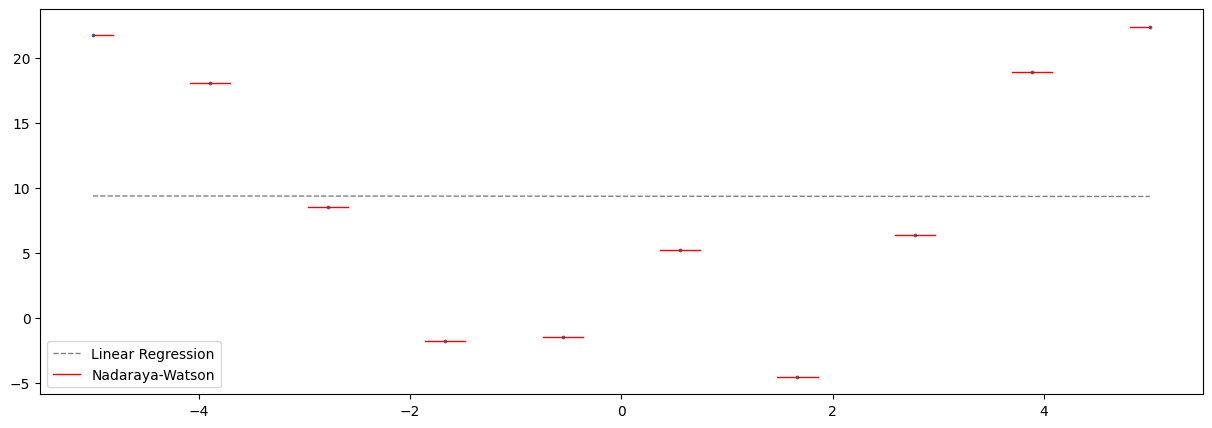

In [11]:
# simulation params
n = 10
x_min = -5
x_max = 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# print(f"observations at x = {x}")
y = x**2 + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n*100)
# print(f"making NW pred at {x_pred}")

h = 0.1 * (1/np.pi)
h = 0.2
y_pred_nw = nadaraya_watson_argmin(x, y, x_pred, 'rect', h=h)

# Plot the original data and the regression line
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=3)
plt.plot(x, y_pred, color='grey', ls='--', lw=1, label='Linear Regression')
plt.plot(x_pred, y_pred_nw, color='red', lw=1, label='Nadaraya-Watson')

plt.legend()
plt.show()

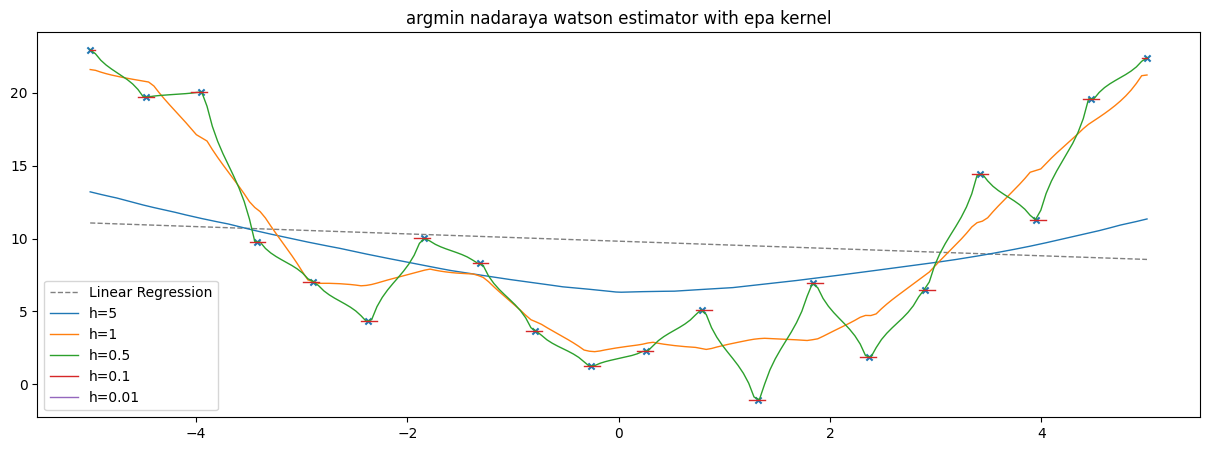

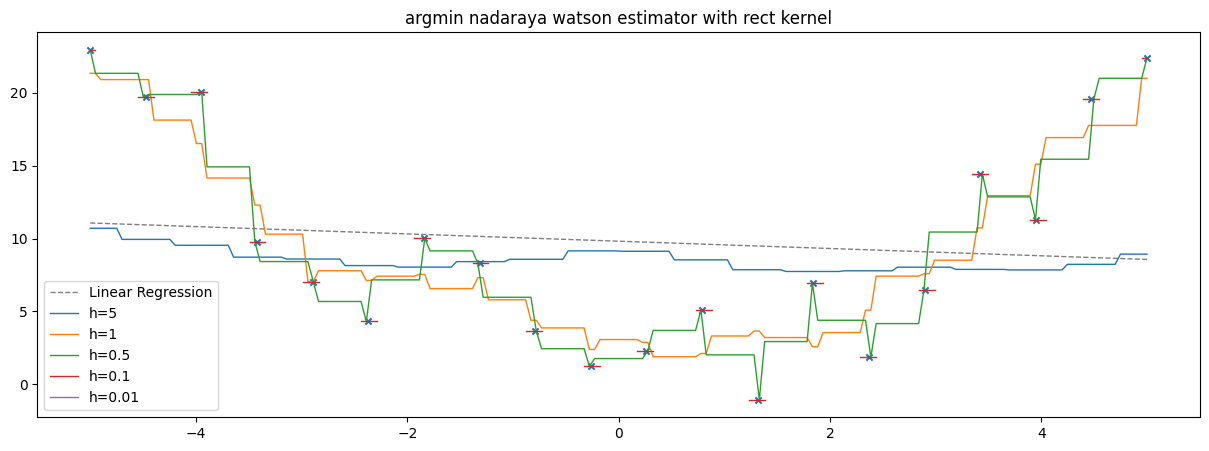

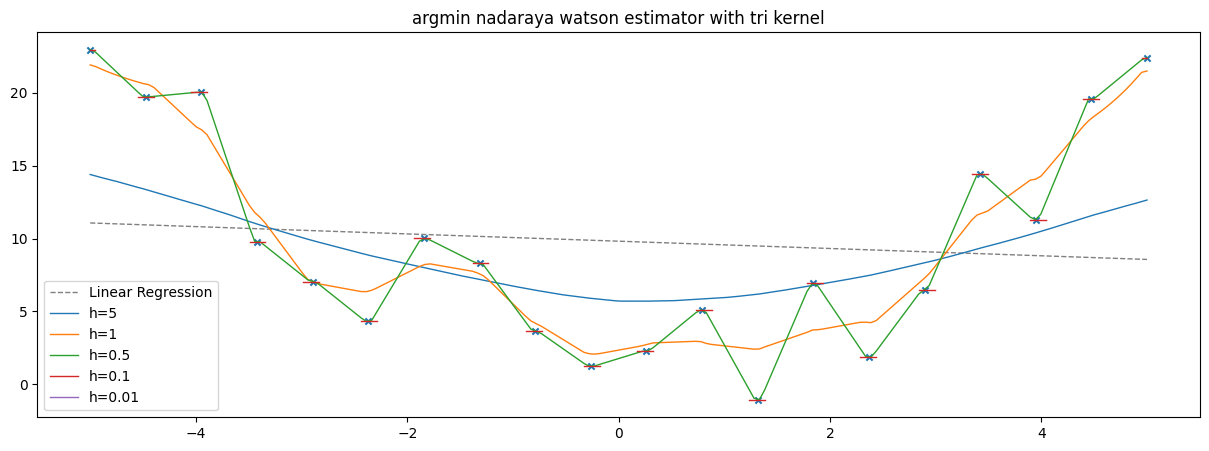

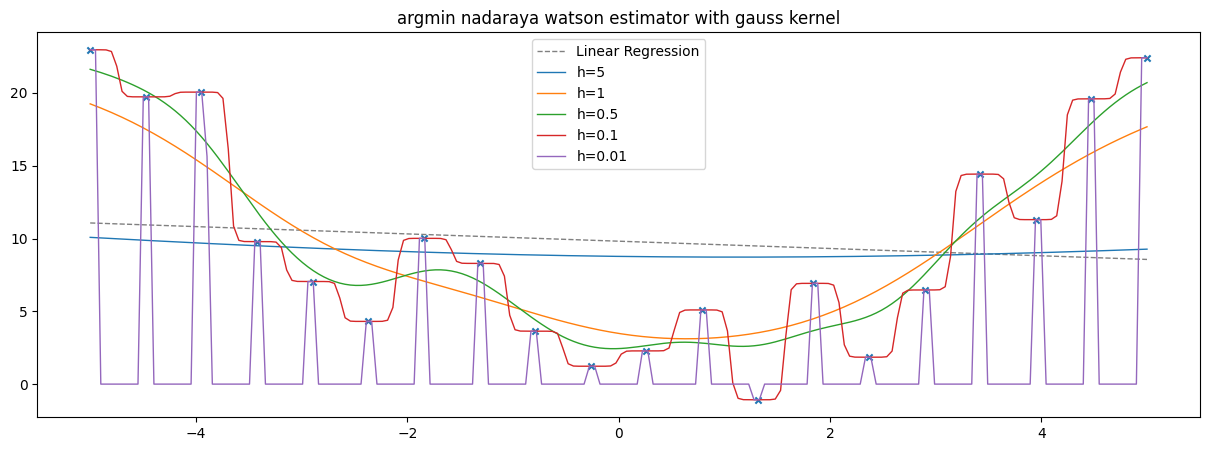

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\Kernel Simulations\kde_funcs.py:37: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, (1/np.pi), np.sin(x)/(np.pi*x))
c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\Kernel Simulations\kde_funcs.py:37: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, (1/np.pi), np.sin(x)/(np.pi*x))


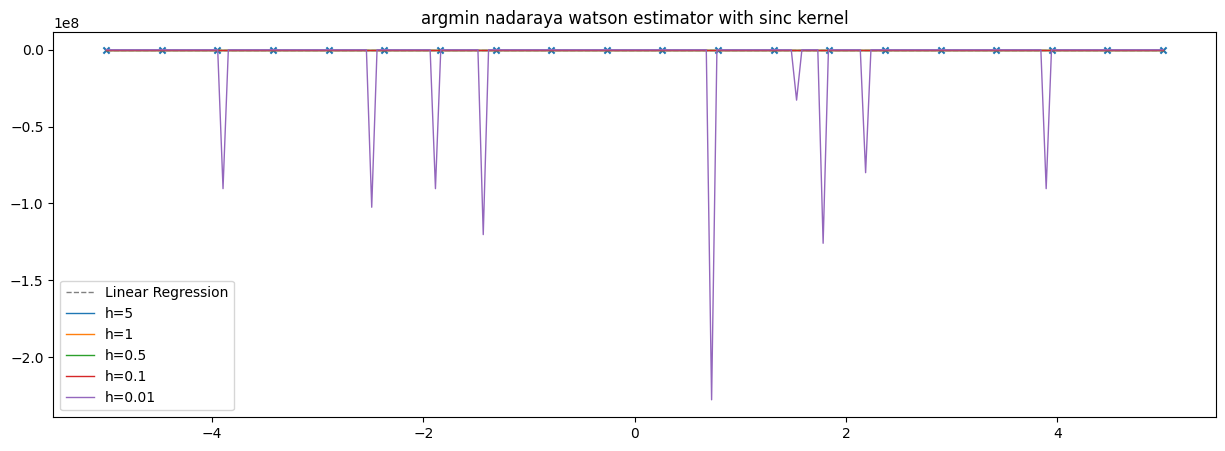

In [12]:
# simulation params
n = 20
x_min = -5
x_max = 5

# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# print(f"observations at x = {x}")
y = x**2 + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n*10)
# print(f"making NW pred at {x_pred}")

kernel_types = ['epa', 'rect', 'tri', 'gauss', 'sinc']
h_arr = [5, 1, 0.5, 0.1, 0.01]

for kernel_type in kernel_types :

    plt.figure(figsize=(15, 5))
    plt.scatter(x, y, s=20, marker='x')
    plt.plot(x, y_pred, color='grey', ls='--', lw=1, label='Linear Regression')

    for h in h_arr :
        y_pred_nw = nadaraya_watson_argmin(x, y, x_pred, kernel_type, h=h)
        plt.plot(x_pred, y_pred_nw, lw=1, label=f'h={h}')

    plt.title(f"argmin nadaraya watson estimator with {kernel_type} kernel")
    plt.legend()
    plt.show()

### TODO : loc linear / polynomial estimator

### TODO : MISE ?